Recurrent spillover with finite population and SIS dynamics WITHOUT death. (no natural death, no disease-induced death)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#class representing one simulation.     
        
class Sim:
    def __init__(self, times, betas, gammas, I, S, spillover_ids):
        
        #these are all arrays of the same length
        self.times = times #all the times of new events (infections and recoveries, including spillover infections)
        self.betas = betas #the corresponding betas. if the event was a recovery, the corresponding beta is "None"
        self.gammas = gammas #the corresponding gammas. if the event was a recovery, the corresponding gamma is "None"
        self.I = I #the number of infecteds, inclusive of the new event
        self.S = S #the number of susceptibles, inclusive of the new event
        self.spillover_ids = spillover_ids #which spillover tree each event belongs to. the spillover trees ids are integers beginning with 0
        
    def append(self, t, beta, gamma, I, S, spillover_id):
        self.times.append(t)
        self.betas.append(beta)
        self.gammas.append(gamma)
        self.I.append(I)
        self.S.append(S)
        self.spillover_ids.append(spillover_id)

In [5]:
def recurrent_sim_finite(S_0, tau, beta_0, gamma_0, mu_1, mu_2, t_thresh = 1000):
    
    t=0

    #initialize return object
    sim = Sim([t], [beta_0], [gamma_0], [1], [S_0], [0])
    
    #keep track of how many spillover trees we have seen so far
    spillovers = 0
    
    #initialize counters
    S = S_0; I = 1
        
    #initialize running sums (over all currently infected people)   
    beta_sum = beta_0; gamma_sum = gamma_0
        
    #initialize matrix of active cases. each case is a row of length 5.
    infecteds=np.array([[beta_0, gamma_0, t, spillovers]])
    
    while True:
        
        #check if we are forced by extinction to stop the simulation
        if tau == 0 and I == 0: return sim             
        if S == 0 and I == 0: return sim
        
        total_pop = S + I #total population 
        
        #grab arrays of all betas gammas deltas
        betas = infecteds[:,0]; gammas = infecteds[:,1]
        
        #adjust betas to actual transmission rates, which depend on proportion of population that is susceptible
        trans_rates = betas*S/total_pop
        trans_rates_sum = beta_sum*S/total_pop #sum all transmission rates 
        
        
        #compute interevent time (for the whole population)
        
        #spillover rate depends on tau and proportion of pop that is susceptible
        spill_rate = tau*S/total_pop

        #rate of events is tau + (sum of transmission rate and gamma and delta) over all infected people
        overall_rate = trans_rates_sum + gamma_sum + spill_rate
        
        #draw from exponential distribution with this rate
        dt = np.random.exponential(scale=1/overall_rate)
        t += dt            
        
        #return if we exceeded t_thresh
        if t > t_thresh: return sim
        
        #figure out whether the event was a new spillover
        event = np.random.rand() #draw from uniform distribution over [0, 1)
        p_spill = spill_rate/overall_rate #probability of spillover
            
        if event < p_spill: #new spillover
            
            #update counters 
            spillovers += 1; I += 1; S -= 1
            
            #append new case to infecteds array
            infecteds = np.append(infecteds, [[beta_0, gamma_0, t, spillovers]], axis=0)

            #update running sums
            beta_sum += beta_0; gamma_sum += gamma_0

            #update return object
            sim.append(t, beta_0, gamma_0, I, S, spillovers)

            continue #skip to next event
        
        
        #otherwise, the event was that somebody either transmitted or recovered

        #figure out who the event happened to
        i = np.random.choice(I, p=(trans_rates + gammas)/(overall_rate - spill_rate)) #index of that person
        
        #grab their specific parameters
        beta = betas[i]; gamma = gammas[i]; trans_rate = beta*S/total_pop
        spillover_id = infecteds[i][3] #the spillover tree they belong to
        
        #figure out what they did, transmit, recover, or die
        ev = np.random.rand() #draw from uniform distribution over [0, 1)
        prob_trans = trans_rate / (trans_rate + gamma) #probability of transmission                
                       
        if (ev < prob_trans): #transmission

            #pick parameters for new case
            #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2, respectively
            #don't allow negative beta, gamma
            mut1 = np.random.normal(loc=0.0, scale=mu_1); mut2 = np.random.normal(loc=0.0, scale=mu_2)
            new_beta = max(0, beta + mut1); new_gamma = max(0, gamma + mut2)

            #append new case to infecteds array
            infecteds = np.append(infecteds, [[new_beta, new_gamma, t, spillover_id]], axis=0)
                        
            #update counters
            I += 1; S -= 1
            
            #update running sums
            beta_sum += new_beta; gamma_sum += new_gamma
            
            #update return object
            sim.append(t, new_beta, new_gamma, I, S, spillover_id)
        
        else: #recovery
            
            #delete them from infecteds array
            infecteds = np.delete(infecteds, i, axis=0)
                        
            #update counters
            I -= 1; S += 1
            
            #update running sums
            beta_sum -= beta; gamma_sum -= gamma
            
            #update return object
            sim.append(t, None, None, I, S, spillover_id)

In [30]:
#color cycles for different spillover trees
def colors(ids):
    dict = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'purple' }
    colors = []
    for id in ids:  
        colors.append(dict[id%6])
    return colors

In [9]:
%%time

#parameters
S_0 = 1000
beta_0 = 0.15
gamma_0 = 0.1
mu = 0.001
tau = 1

t_thresh = 10000

#compute the simulation

mu_1 = mu; mu_2 = mu

s = recurrent_sim_finite(S_0, tau, beta_0, gamma_0, mu_1, mu_2, t_thresh)
        
times = s.times; betas = s.betas; gammas = s.gammas; I = s.I; S = s.S; spillover_ids = s.spillover_ids

CPU times: user 15.7 s, sys: 135 ms, total: 15.9 s
Wall time: 16.1 s


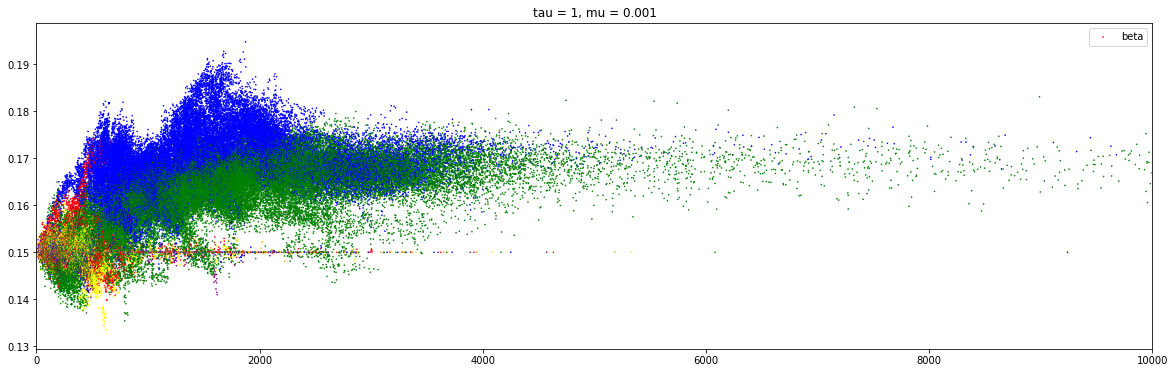

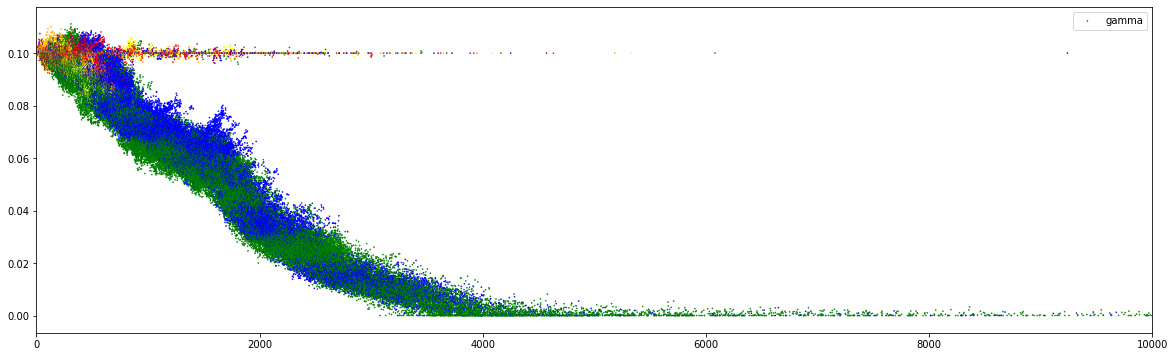

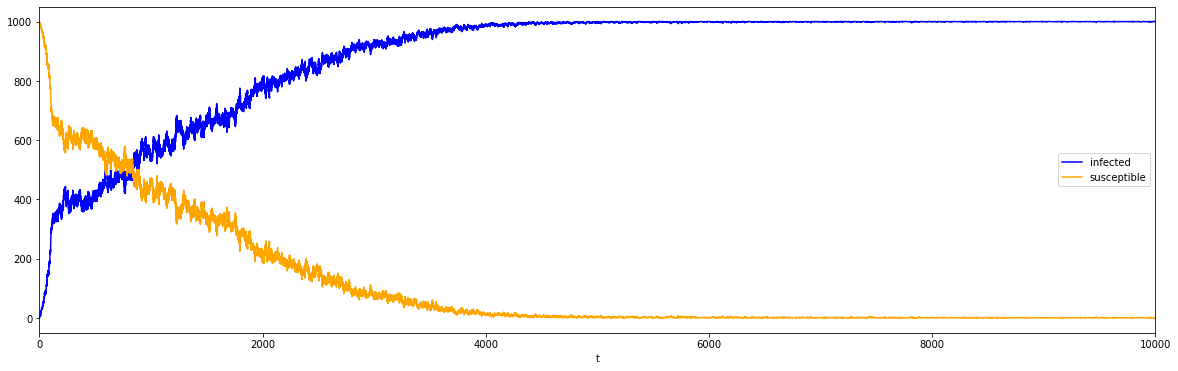

In [31]:
#plots

#view options
autoscale_x = False
x_max = 10000
fig_h = 20
fig_w = 6

############################################ OPTION 1 #########################################################
############# plot each parameter separately, distinguishing between different spillover trees ################

#plot betas over time
plt.figure(figsize=(fig_h, fig_w))
plt.scatter(times, betas, marker = ".", s = 1.5, c=colors(spillover_ids), label = 'beta')
plt.title('tau = {}, mu = {}'.format(tau, mu))
if autoscale_x: plt.autoscale(enable=True, axis='x', tight=True) 
else: plt.xlim(0, x_max)
plt.legend(loc="upper right") 
plt.show()

#plot gammas over time
plt.figure(figsize=(fig_h, fig_w))
plt.scatter(times, gammas, marker = ".", s = 1.5, c=colors(spillover_ids), label = 'gamma')
if autoscale_x: plt.autoscale(enable=True, axis='x', tight=True)
else: plt.xlim(0, x_max)
plt.legend(loc="upper right")
plt.show()


############################################ OPTION 2 #########################################################
################################# plot each parameter separately ##############################################
########################### without distinguishing between spillover trees ####################################

# #plot betas over time
# plt.figure(figsize=(fig_h, fig_w))
# plt.plot(times, betas, ",r", label='beta')
# plt.title('tau = {}, mu = {}'.format(tau, mu_1))
# if autoscale_x: plt.autoscale(enable=True, axis='x', tight=True)
# else: plt.xlim(0, x_max)
# plt.legend(loc="upper right")
# plt.show()

# #plot gammas over time 
# plt.figure(figsize=(fig_h, fig_w))
# plt.plot(times, gammas, ",g", label='gamma')
# if autoscale_x: plt.autoscale(enable=True, axis='x', tight=True)
# else: plt.xlim(0, x_max)
# plt.legend(loc="upper right")
# plt.show()


############################################ OPTION 3 #########################################################
################################# plot both parameters together ###############################################
########################### without distinguishing between spillover trees ####################################

# #plot parameters over time
# plt.figure(figsize=(fig_h, fig_w))
# plt.plot(times, betas, ".r", label='beta')
# plt.plot(times, gammas, ".g", label='gamma')
# plt.title('tau = {}, mu_1 = {}, mu_2 = {}'.format(tau, mu_1, mu_2))
# plt.xlabel("t"); plt.ylabel("parameters")
# if autoscale_x: plt.autoscale(enable=True, axis='x', tight=True)
# else: plt.xlim(0, x_max)
# plt.legend(); plt.show()

###############################################################################################################

#plot infecteds, susceptible over time
plt.figure(figsize=(fig_h, fig_w))
plt.plot(times, I, 'blue', label='infected')
plt.plot(times, S, 'orange', label='susceptible')
plt.xlabel("t")
if autoscale_x: plt.autoscale(enable=True, axis='x', tight=True)
else: plt.xlim(0, x_max)
plt.legend(loc="center right")
plt.show()

In [11]:
import pickle

In [12]:
#save interesting simulations

#10000 days simulation with tau = 1, mu = 0.001, beta = 0.15, gamma = 0.1, S_0 = 1000
#pickled to: s_competing_strains_10000.txt

#coexistence (10000 days with tau = 1, mu = 0.001, beta = 0.15, gamma = 0.1, S_0 = 1000)
#pickled to: s_coexistence

file = open('filename.txt', 'wb')
pickle.dump(s, file)
file.close()

In [21]:
#open a pickled simulation

file = open('s_coexistence.txt', 'rb')
s_pickled = pickle.load(file)
file.close()